In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
from scipy.stats import zscore

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 2

# Load in data

In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 238 ms, sys: 1.23 s, total: 1.47 s
Wall time: 6.09 s


AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [3]:
adata.uns['pooled_condition_colors']

array(['silver', '#F5A35B', '#9B5CA6', '#9ECAE1'], dtype=object)

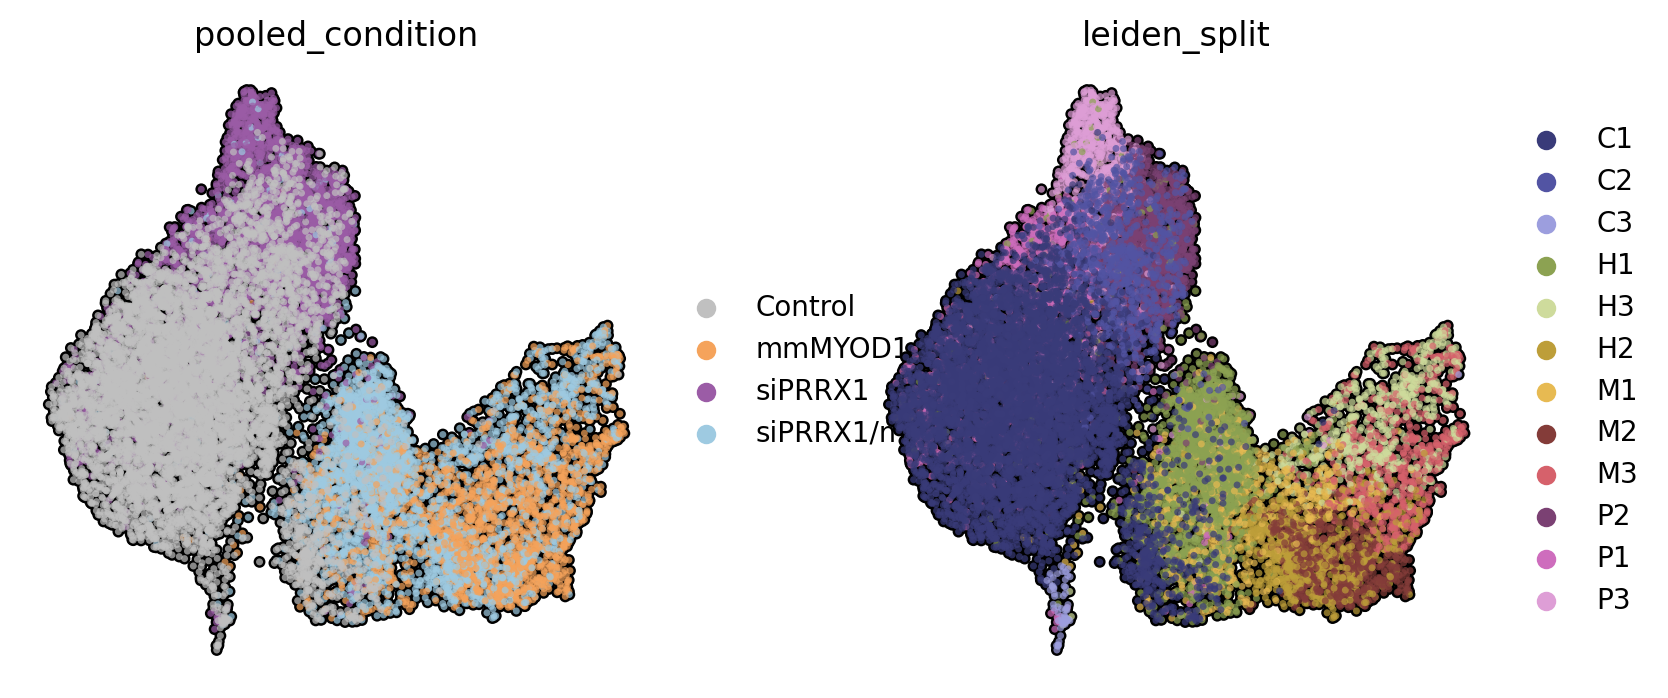

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    adata,
    color=['pooled_condition', 'leiden_split'],
    size=25,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
)

# DGE

In [4]:
def get_significant_DEGs(df, alpha=0.05, logfc_thresh=0.5, pct_nz_thresh=0.0):
    
    tmp = df.copy()
    
    print(f"Filtering for significant DEGs (adjusted p-value < {alpha}, logfoldchange > {logfc_thresh})...")

    tmp['abs_lfc'] = tmp['logfoldchanges'].apply('abs')
    tmp = tmp[(tmp['abs_lfc'] > logfc_thresh) & (tmp['pvals_adj'] < alpha)]

    if pct_nz_thresh != 0.0:
        if 'pct_nz_reference' in tmp.columns:
            # make sure either group of interest OR reference has % cells expressing above threshold
            tmp = tmp[(tmp['pct_nz_group'] > pct_nz_thresh) | (tmp['pct_nz_reference'] > pct_nz_thresh)]
            print(f"Removed genes expressed in less than {pct_nz_thresh*100}% of group OR reference cells.")
        
        else:
            # Only apply pct_nz_group filter to upregulated genes
            upregulated_mask = tmp['logfoldchanges'] > 0
            keep_mask = (~upregulated_mask) | (tmp['pct_nz_group'] > pct_nz_thresh)
            tmp = tmp[keep_mask]

            tmp = tmp[tmp['pct_nz_group'] > pct_nz_thresh]
            print(f"Removed upregaulted genes expressed in less than {pct_nz_thresh*100}% of cells. Kept all downregulated genes.")
    
    print(f"N unique significant DEGs: {tmp['names'].nunique()}\n")
    
    return tmp

## By condition

In [5]:
# each condition vs control
sc.tl.rank_genes_groups(
    adata,
    groupby='pooled_condition',
    reference='Control',
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='condition_deg',
)

ranking genes
    finished (0:00:59)


In [6]:
deg_key = 'condition_deg'

deg = sc.get.rank_genes_groups_df(
    adata,
    group=None,
    key=deg_key,
)

sig = get_significant_DEGs(deg, pct_nz_thresh=0.3)
sig.head()

Filtering for significant DEGs (adjusted p-value < 0.05, logfoldchange > 0.5)...
Removed upregaulted genes expressed in less than 30.0% of cells. Kept all downregulated genes.
N unique significant DEGs: 3790



,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc
0,mmMYOD1,MYOD1,69.678673,32.184513,0.0,0.0,1.000000,32.184513
1,mmMYOD1,MT-ND4,69.559166,2.778089,0.0,0.0,0.999526,2.778089
2,mmMYOD1,LINC-PINT,59.171329,2.708041,0.0,0.0,0.970128,2.708041
3,mmMYOD1,NAV3,58.639927,3.446840,0.0,0.0,0.924609,3.446840
4,mmMYOD1,TAF1D,55.636890,2.705306,0.0,0.0,0.960645,2.705306


In [10]:
# get gene annotation info
gtf = adata.var[['gene_type']].copy()
gtf = gtf.reset_index(names='names')
print(gtf.shape)


# get TF info
fpath = "../../resources/HumanTF_v_1.01.csv"

tdf = pd.read_csv(fpath)
tdf = tdf[['HGNC symbol', 'Is TF?']]
tdf = tdf.rename(columns={'HGNC symbol': 'gene_name', 'Is TF?': 'is_tf'})
tdf = tdf[tdf['is_tf'] == 'Yes']
tdf = tdf.drop_duplicates(subset='gene_name')
display(tdf.head())

tf_list = tdf['gene_name'].unique()
print(f"N TFs total: {len(tf_list)}")

# add TF column to gtf
gtf['is_tf'] = gtf['names'].isin(tf_list)
print(f"N TFs in adata: {gtf['is_tf'].value_counts()}")


# merge with DEGs
sig = pd.merge(sig, gtf, how='left', on='names')
print(sig.shape)
sig.head()

(25042, 2)


,gene_name,is_tf
0,TFAP2A,Yes
1,TFAP2B,Yes
2,TFAP2C,Yes
3,TFAP2D,Yes
4,TFAP2E,Yes


N TFs total: 1639
N TFs in adata: is_tf
False    23685
True      1357
Name: count, dtype: int64
(6981, 10)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc,gene_type,is_tf
0,mmMYOD1,MYOD1,69.678673,32.184513,0.0,0.0,1.000000,32.184513,protein_coding,True
1,mmMYOD1,MT-ND4,69.559166,2.778089,0.0,0.0,0.999526,2.778089,protein_coding,False
2,mmMYOD1,LINC-PINT,59.171329,2.708041,0.0,0.0,0.970128,2.708041,lncRNA,False
3,mmMYOD1,NAV3,58.639927,3.446840,0.0,0.0,0.924609,3.446840,protein_coding,False
4,mmMYOD1,TAF1D,55.636890,2.705306,0.0,0.0,0.960645,2.705306,protein_coding,False


filtering for protein_coding genes...


direction,down,up
group,,
siPRRX1,-351,1564
siPRRX1/mmMYOD1,-577,1520
mmMYOD1,-807,1846


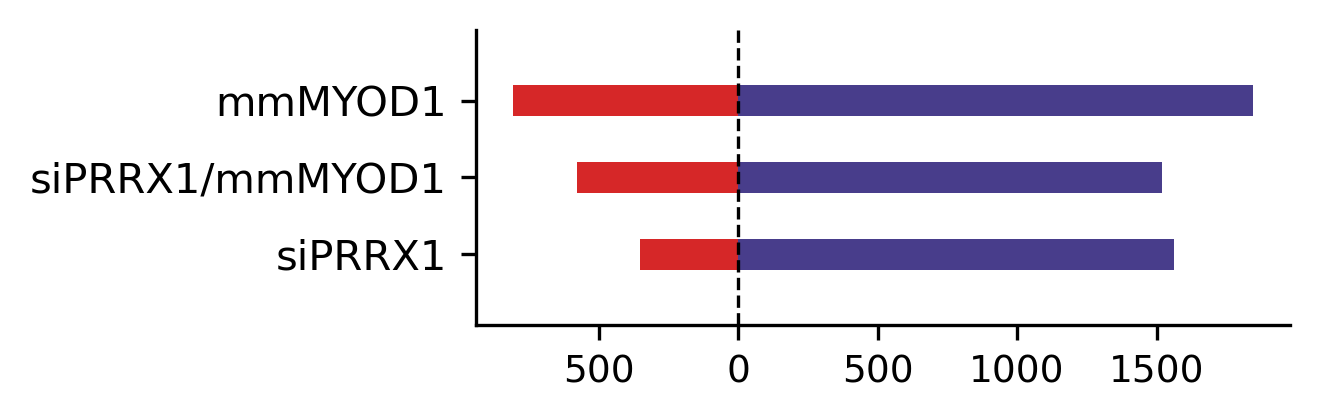

In [20]:
### How many DEGs?

tmp = sig.copy()

tmp['direction'] = tmp['logfoldchanges'].apply(lambda x: 'up' if x > 0 else 'down')


# filter for gene types of interest
gene_type = 'protein_coding'

if gene_type != 'all':
    tmp = tmp[tmp['gene_type'] == gene_type]
    print(f"filtering for {gene_type} genes...")


counts = tmp.groupby(['group', 'direction'], observed=True).size().reset_index(name='count')
counts['count'] = counts.apply(lambda row: -row['count'] if row['direction'] == 'down' else row['count'], axis=1)
plot_df = counts.pivot(index='group', columns='direction', values='count').fillna(0)

plot_order = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']
plot_df = plot_df.reindex(plot_order)
display(plot_df)

# plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 1.5
fig, ax = plt.subplots()

bar_width = 0.4

ax.barh(plot_df.index, plot_df['up'], color='darkslateblue', label='Up', height=bar_width)
ax.barh(plot_df.index, plot_df['down'], color='tab:red', label='Down', height=bar_width)

ax.axvline(0, color='k', linewidth=0.8, ls='--')

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_yticks(range(len(plot_df.index)))
ax.set_yticklabels(plot_order)
ax.margins(y=0.3)

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: int(abs(x))))
ax.tick_params(axis='x', labelsize=9)

sns.despine()
plt.tight_layout()
plt.show()

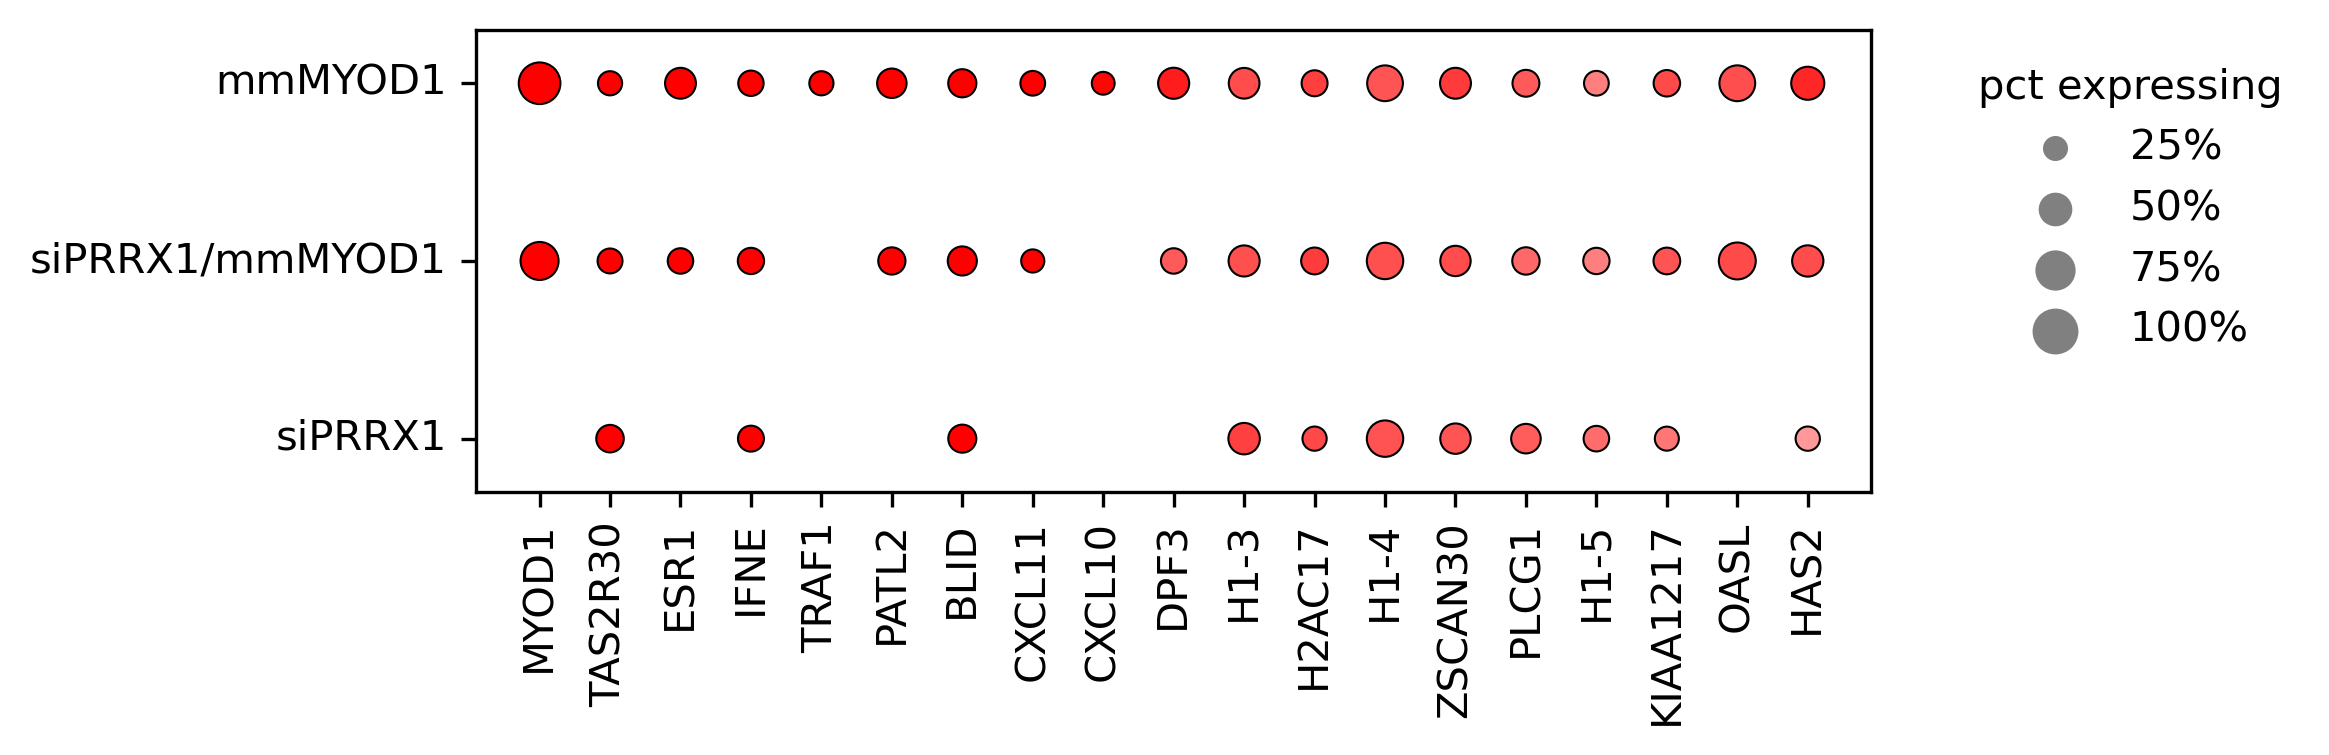

In [29]:
### Top DEGs

top_n_genes = 10

groups = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']
groups.reverse()


sort_col = 'logfoldchanges'

pdf = sig.sort_values(by=['group', sort_col], ascending=[True, False])

# remove ENSG, MT, and ribo genes
pdf = pdf[~pdf['names'].str.startswith(('ENSG', 'MT-', 'RP'))]
# keep only protein-coding
pdf = pdf[pdf['gene_type'] == 'protein_coding']


pdf = pdf.groupby('group').head(top_n_genes)
deg_genes = pdf['names'].unique()

# filter full df for these genes
plot_df = sig[sig['names'].isin(deg_genes)].copy()
plot_df = plot_df.sort_values(by=['group', sort_col], ascending=[True, False])

plot_df['names'] = pd.Categorical(plot_df['names'], categories=deg_genes, ordered=True)
plot_df['group'] = pd.Categorical(plot_df['group'], categories=groups, ordered=True)



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(
    data=plot_df,
    x='names',
    y='group',
    hue='logfoldchanges',
    size='pct_nz_group',
    # size='logfoldchanges',
    sizes=(30, 100),
    ec='k',
    lw=0.5,
    hue_norm=(-5, 5),
    # legend=False,
    palette='bwr',
)

plt.margins(y=0.15)
plt.ylabel("")
plt.xlabel("")

ax = plt.gca()

sizes = [25, 50, 75, 100]
markers = [plt.scatter([], [], s=s, color='gray') for s in sizes]
labels = [f"{s}%" for s in sizes]

ax.legend(markers, labels, title="pct expressing", scatterpoints=1,
          frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

ax = plt.gca()
y_labels = ax.get_yticklabels()
y_ticks = ax.get_yticks()
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(y_ticks, y_labels, rotation=0, va='center')

plt.show()

In [28]:
### per group, how many DE TFs? 
tmp = sig.copy()

tmp['direction'] = tmp['logfoldchanges'].apply(lambda x: 'up' if x > 0 else 'down')

counts = tmp.groupby(['group', 'is_tf'], observed=True).size().reset_index(name='count')

plot_df = counts.pivot(index='group', columns='is_tf', values='count').fillna(0)

plot_order = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']
plot_df = plot_df.reindex(plot_order)
display(plot_df)


### how many lncRNA vs protein-coding?
tmp = sig.copy()

counts = tmp.groupby(['group', 'gene_type'], observed=True).size().reset_index(name='count')

plot_df = counts.pivot(index='group', columns='gene_type', values='count').fillna(0)

plot_order = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']
plot_df = plot_df.reindex(plot_order)

plot_df['total'] = plot_df.sum(axis=1)
plot_df['pct_lnc'] = (plot_df['lncRNA'] / plot_df['total']) * 100

display(plot_df)

is_tf,False,True
group,,
siPRRX1,1887,117
siPRRX1/mmMYOD1,2064,137
mmMYOD1,2587,189


gene_type,lncRNA,protein_coding,total,pct_lnc
group,,,,
siPRRX1,89,1915,2004,4.441118
siPRRX1/mmMYOD1,104,2097,2201,4.725125
mmMYOD1,123,2653,2776,4.430836


In [27]:
# from scipy.stats import fisher_exact, chi2_contingency

# oddsratio, p = fisher_exact(plot_df)
# print(oddsratio, p)
# # or
# chi2, p, dof, exp = chi2_contingency(plot_df)
# print(chi2, p, dof, exp)

0.002395783436792358 0.8722
0.29351574307485806 0.8635030307676799 2 [[  90.71250537 1913.28749463]
 [  99.62985246 2101.37014754]
 [ 125.65764217 2650.34235783]]


In [35]:
### Overlap

tmp = sig.copy()
tmp['direction'] = tmp['logfoldchanges'].apply(lambda x: 'up' if x > 0 else 'down')

# filter for specific direction
direction = 'up'
tmp = tmp[tmp['direction'] == direction]

# obtain gene lists
myod_genes = set(tmp[tmp['group'] == 'mmMYOD1']['names'].unique())
prrx_genes = set(tmp[tmp['group'] == 'siPRRX1']['names'].unique())
hyb_genes = set(tmp[tmp['group'] == 'siPRRX1/mmMYOD1']['names'].unique())


shared_myod = list((myod_genes & hyb_genes) - prrx_genes)
print(f"Shared by mmMYOD1 and HYB: {len(shared_myod)}\n{', '.join(sorted(shared_myod))}\n")

unique_to_myod = list(myod_genes - prrx_genes - hyb_genes)
print(f"Unique to mmMYOD1 only: {len(unique_to_myod)}\n{', '.join(sorted(unique_to_myod))}\n")


unique_to_hyb = list(hyb_genes - prrx_genes - myod_genes)
print(f"Unique to HYB: {len(unique_to_hyb)}\n{', '.join(sorted(unique_to_hyb))}\n")

unique_to_prrx = list(prrx_genes - hyb_genes - myod_genes)
print(f"Unique to siPRRX1 only: {len(unique_to_prrx)}\n{', '.join(sorted(unique_to_prrx))}\n")

shared_by_all = list(prrx_genes & hyb_genes & myod_genes)
print(f"Shared by all: {len(shared_by_all)}\n{', '.join(sorted(shared_by_all))}\n")

Shared by mmMYOD1 and HYB: 543
AATF, ABHD5, ABRACL, ACBD5, ACKR4, ACYP2, ADAMTS12, ADPRS, AEBP2, AFAP1, AFF1, AFF4, AKAP10, ALAS1, ANAPC10, ANKDD1A, ANKFY1, ANKLE2, ANTXR2, AOPEP, APOBEC3F, APOBEC3G, APOL2, ARGLU1, ARHGAP29, ARHGEF28, ARID4B, ARL14EP, ARMCX1, ARRDC3, ATF3, ATP10A, ATP10D, ATP13A3, ATP6V1C1, ATRIP, ATXN2L, ATXN7, AZI2, BACH1, BATF2, BAZ1A, BCL10, BCL2L13, BDP1, BIRC2, BLZF1, BMAL2, BMPR1A, BRD2, BTN2A1, C15orf48, C16orf87, C18orf21, C1GALT1, C1orf21, C21orf91, C2orf49, C3orf38, C8orf76, CAMK2D, CASP1, CASP3, CASP4, CASP8, CCDC12, CCDC14, CCDC171, CCDC174, CCDC91, CCND3, CCNL1, CD274, CD2AP, CDC42SE2, CDC73, CDKN2AIP, CEMIP2, CEP170, CERT1, CES2, CFH, CFLAR, CGAS, CHFR, CIR1, CMPK2, CNDP2, CNOT4, COA6, COG3, COIL, COQ10B, COX10, COX19, CPEB4, CPED1, CRCP, CREB1, CREM, CTDSPL2, CTNNBL1, CTSS, CTTNBP2NL, CXCL11, CYLD, DAXX, DCP1A, DCUN1D5, DDIT3, DDX47, DDX60, DDX60L, DENND5A, DGLUCY, DHX36, DHX58, DMTF1, DNTTIP2, DPF3, DRAM1, DSP, DTX3L, DZIP1L, EHD1, EHD4, EIF3M, EIF4E, 

In [36]:
# each condition vs control
sc.tl.rank_genes_groups(
    adata,
    groupby='pooled_condition',
    reference='mmMYOD1',
    groups=['siPRRX1/mmMYOD1'],
    method='wilcoxon',
    layer='log_norm',
    use_raw=False,
    pts=True,
    key_added='myod_vs_hyb',
)

ranking genes
    finished (0:00:10)


In [38]:
deg_key = 'myod_vs_hyb'

deg = sc.get.rank_genes_groups_df(
    adata,
    group=None,
    key=deg_key,
)

# deg.head()
sig = get_significant_DEGs(deg, pct_nz_thresh=0.3)
sig.head()

Filtering for significant DEGs (adjusted p-value < 0.05, logfoldchange > 0.5)...
Removed upregaulted genes expressed in less than 30.0% of cells. Kept all downregulated genes.
N unique significant DEGs: 721



,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc
0,LGALS1,34.102398,0.894991,6.796089e-255,1.701877e-250,0.995943,0.894991
1,IFITM3,31.239761,0.681197,3.075090e-214,2.566880e-210,0.999131,0.681197
2,IFITM2,30.667830,1.149966,1.528904e-206,9.571704e-203,0.962040,1.149966
3,TMSB10,29.002615,0.603551,6.098401e-185,3.054323e-181,1.000000,0.603551
4,CD99,28.796171,1.243713,2.395363e-182,9.997445e-179,0.891626,1.243713


In [39]:
sig.sort_values(by='logfoldchanges', ascending=False).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,abs_lfc
307,KDELR3,11.747437,1.388007,7.279317e-32,4.229435e-30,0.320197,1.388007
11,CALR,26.087030,1.376282,5.116659e-150,9.856259e-147,0.819473,1.376282
266,LDLR,12.410585,1.358486,2.289719e-35,1.566643e-33,0.341640,1.358486
9,PTN,26.765038,1.328712,8.252588e-158,1.878739e-154,0.900609,1.328712
5,MDK,28.354147,1.313917,7.440636e-177,2.661834e-173,0.881484,1.313917
50,PDIA4,20.419025,1.286373,1.133036e-92,4.809065e-90,0.642422,1.286373
281,GGH,12.146035,1.260115,6.021526e-34,3.856549e-32,0.352362,1.260115
4,CD99,28.796171,1.243713,2.395363e-182,9.997445e-179,0.891626,1.243713
235,IDI1,12.875175,1.208159,6.209799e-38,4.726619e-36,0.397566,1.208159
15,HSP90B1,24.148672,1.195635,7.710212e-129,1.135760e-125,0.907853,1.195635
